In [15]:

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Define the path to  data in Google Drive
train_data_path = '/content/drive/My Drive/Processed/train/'

# Copy data from Drive to local Colab storage for faster processing
!cp -r "$train_data_path" /content/

In [17]:
# Define the path to  data in Google Drive
test_data_path = '/content/drive/My Drive/Processed/val/'

# Copy data from Drive to local Colab storage for faster processing
!cp -r "$test_data_path" /content/

In [19]:
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torchmetrics
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [20]:
torch.manual_seed(42)

In [21]:
labels = pd.read_csv("/content/drive/MyDrive/stage_2_train_labels.csv")
# Remove duplicate entries
labels = labels.drop_duplicates("patientId")

In [22]:
labels.head(5)[['patientId', 'Target']]  # Checking the sample Label .'Target' is the label

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [23]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1),antialias=True)

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])



In [24]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [25]:
train_dataset = torchvision.datasets.DatasetFolder(
    "/content/train",
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    "/content/val",
    loader=load_file, extensions="npy", transform=val_transforms)

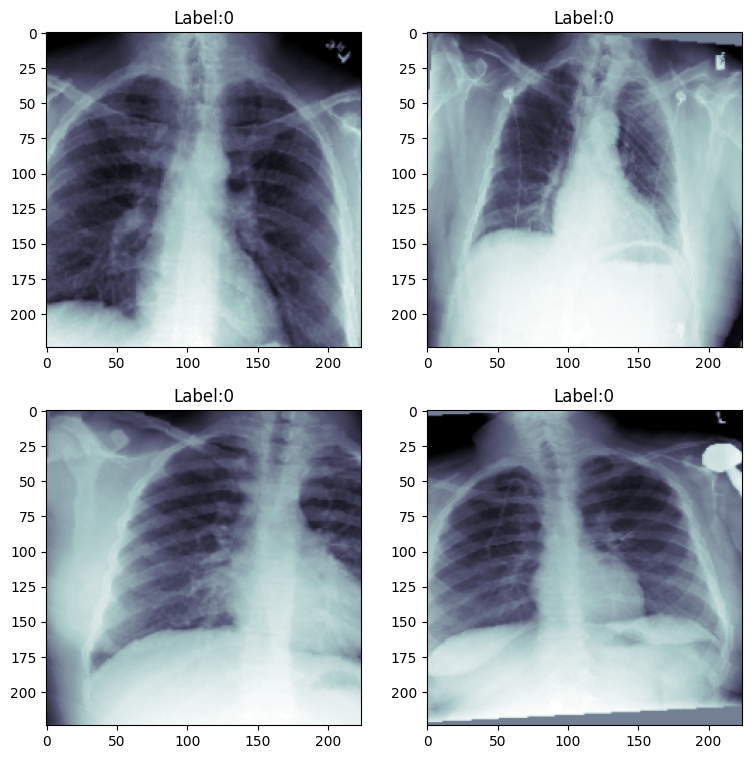

In [26]:
#Visualizing some Samples with their labels
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

In [27]:
train_dataset[0][0].shape

torch.Size([1, 224, 224])

In [28]:
batch_size = 256
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


In [29]:
 import torchvision.models as models

 class CustomNet(nn.Module):
     def __init__(self, num_classes=1):
         super(CustomNet, self).__init__()

         # Load pre-trained ResNet-50
         self.resnet = models.resnet50(weights='DEFAULT')

         # Change the input channel of the first convolution layer to 1 since we are working with greyscale image
         self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
         # Change the output layer for binary classification to 1 for binary classification
         self.resnet.fc = nn.Linear(2048, num_classes)  # 'num_classes' should be 1 for binary classification

     def forward(self, x):
         x = self.resnet(x)
         return x


 # Instantiate the custom model using ResNet-50 features
 model = CustomNet()
 print("Custom CNN model using ResNet-50 features defined!")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 81.7MB/s]


Custom CNN model using ResNet-50 features defined!


In [30]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)

        target = target.view(-1, 1)  # Reshape to [batch_size, 1]


        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)



        target = target.type_as(output)  # Cast target to the same data type as output

        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print(f'Training set:{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader)} Loss:{loss.item()})')
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [31]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    target_all = []
    predicted_all = []

    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted classes for this batch
            output = model(data)
            outputs = torch.sigmoid(output)
            preds = (outputs > 0.5).float()


            target = target.view(-1, 1)

            target = target.type_as(preds)  # Cast target to the same data type as output

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()


            # Calculate the accuracy for this batch
            correct += torch.sum(preds == target).item()

             # Append scalar target and predicted values after moving into cpu
            target_all.extend(target.cpu().numpy())
            predicted_all.extend(preds.cpu().numpy())

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count

    # Calculate Precision, Recall, and F1-score using scikit-learn functions
    precision = round(precision_score(target_all, predicted_all, average='weighted'),2)
    recall = round(recall_score(target_all, predicted_all, average='weighted'),2)
    f1 = round(f1_score(target_all, predicted_all, average='weighted'),2)
    precision2 = round(precision_score(target_all, predicted_all, average='binary'),2)
    recall2 = round(recall_score(target_all, predicted_all, average='binary'),2)
    f1_2 = round(f1_score(target_all, predicted_all, average='binary'),2)
    accuracy = round((accuracy_score(target_all, predicted_all)*100),2)
    # Printing the accuracy
    print(f'Validation set: Average loss: {avg_loss},Accuracy: {accuracy}%, Weighted precision:{precision}, Weighted recall:{recall},Weighted f1:{f1}')
    print(f'Positive_class:  precision:{precision2},  recall:{recall2}, f1:{f1_2}')
   # return average loss for the epoch
    return avg_loss,accuracy, precision, recall, f1

In [32]:
torch.cuda.empty_cache()

Training model with class weight: 1.0
Training on cuda
Epoch: 1
Training set:0/24000 (0.0 Loss:0.6843595504760742)
Training set:2560/24000 (10.638297872340425 Loss:0.44585198163986206)
Training set:5120/24000 (21.27659574468085 Loss:0.38018178939819336)
Training set:7680/24000 (31.914893617021278 Loss:0.47993534803390503)
Training set:10240/24000 (42.5531914893617 Loss:0.39886197447776794)
Training set:12800/24000 (53.191489361702125 Loss:0.38768112659454346)
Training set:15360/24000 (63.829787234042556 Loss:0.3695801794528961)
Training set:17920/24000 (74.46808510638297 Loss:0.40002205967903137)
Training set:20480/24000 (85.1063829787234 Loss:0.4133264720439911)
Training set:23040/24000 (95.74468085106383 Loss:0.3676585257053375)
Training set: Average loss: 0.432945
Validation set: Average loss: 0.39877539602192963,Accuracy: 82.68%, Weighted precision:0.81, Weighted recall:0.83,Weighted f1:0.8
Positive_class:  precision:0.73,  recall:0.37, f1:0.49
Epoch: 2
Training set:0/24000 (0.0 Lo

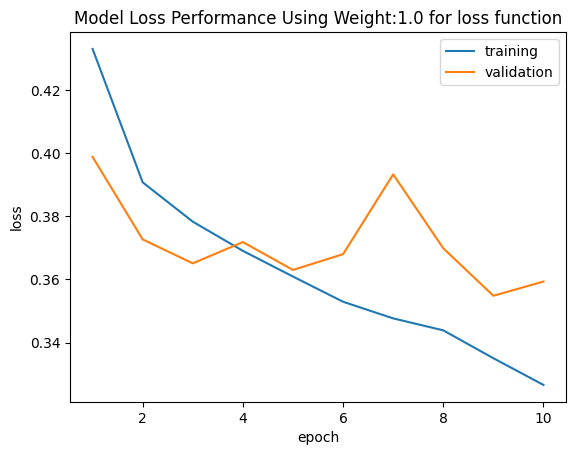

Using Weight 1.0,Best model found at epoch 9, with validation loss: 0.3548085364428433
Using Weight 1.0,Best Accuracy found at epoch 2, with Accuracy : 84.31%
Using Weight 1.0,Best Weighted Precision found at epoch 2, with Precision : 0.84
Using Weight 1.0,Best Weighted Recall found at epoch 2, with Recall : 0.84
Using Weight 1.0,Best Weighted F1 found at epoch 2, with F1 : 0.84
Training model with class weight: 4.440000057220459
Training on cuda
Epoch: 1
Training set:0/24000 (0.0 Loss:1.0667401552200317)
Training set:2560/24000 (10.638297872340425 Loss:0.6386690139770508)
Training set:5120/24000 (21.27659574468085 Loss:0.7984268665313721)
Training set:7680/24000 (31.914893617021278 Loss:0.6697965860366821)
Training set:10240/24000 (42.5531914893617 Loss:0.7901163697242737)
Training set:12800/24000 (53.191489361702125 Loss:0.6701345443725586)
Training set:15360/24000 (63.829787234042556 Loss:0.5269862413406372)
Training set:17920/24000 (74.46808510638297 Loss:0.7130126357078552)
Traini

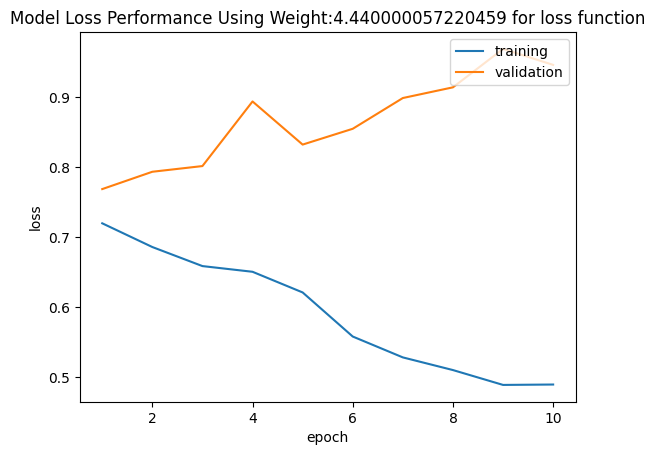

Using Weight 4.440000057220459,Best model found at epoch 1, with validation loss: 0.7683872336691077
Using Weight 4.440000057220459,Best Accuracy found at epoch 4, with Accuracy : 80.25%
Using Weight 4.440000057220459,Best Weighted Precision found at epoch 1, with Precision : 0.84
Using Weight 4.440000057220459,Best Weighted Recall found at epoch 4, with Recall : 0.8
Using Weight 4.440000057220459,Best Weighted F1 found at epoch 4, with F1 : 0.81
Overall Best model found at Using Weight 1.0, with validation loss: 0.3548085364428433 at epoch 9
Overall Best Accuracy found at Using Weight 1.0, with Accuracy : 84.31% at epoch 2 
Overall Best Weighted Precision found at Using Weight 1.0, with Precision : 0.84 at epoch 2 
Overall Best Weighted Recall found at Using Weight 1.0, with Recall : 0.84 at epoch 2 
Overall Best Weighted F1 found at Using Weight 1.0, with F1 : 0.84 at epoch 2 


In [33]:
pos_weights = [1, 4.44]
pos_weights = torch.tensor(pos_weights, dtype=torch.float32)


overall_validation_loss=float('inf')
overall_validation_loss_details = []
over_all_best_F1 = []
over_all_best_precision = []
over_all_best_recall = []
over_all_best_accuracy = []

for weight in pos_weights:
    print(f"Training model with class weight: {weight}")
    device = "cpu"
    if (torch.cuda.is_available()):
        # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
        device = "cuda"
    print('Training on', device)

    # Create an instance of the model class and allocate it to the device
    model = model.to(device)

    # Use an "Adam" optimizer to adjust weights
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Define the weighted loss function
    loss_criteria = torch.nn.BCEWithLogitsLoss(pos_weight=weight)



    # Track metrics in these arrays
    epoch_nums = []
    training_loss = []
    validation_loss = []
    best_loss = float('inf')  # Initialize with a high value
    best_epoch = 0
    best_F1 = 0
    best_F1_epoch = 0
    best_precision = 0
    best_precision_epoch = 0
    best_recall = 0
    best_recall_epoch = 0
    best_accuracy = 0
    best_accuracy_epoch = 0
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

    # Train over  epochs
    epochs = 10
    for epoch in range(1, epochs + 1):
            train_loss = train(model, device, train_loader, optimizer, epoch)
            test_loss, accuracy, precision, recall, f1 = test(model, device, test_loader)
            epoch_nums.append(epoch)
            training_loss.append(train_loss)
            validation_loss.append(test_loss)
            # Save the model with the lowest validation loss
            if test_loss < best_loss:
              best_loss = test_loss
              best_epoch = epoch
            if accuracy > best_accuracy:
              best_accuracy = accuracy
              best_accuracy_epoch = epoch
            if precision > best_precision:
              best_precision = precision
              best_precision_epoch = epoch
            if recall > best_recall:
              best_recall = recall
              best_recall_epoch = epoch
            if f1 > best_F1:
              best_F1 = f1
              best_F1_epoch = epoch
            if test_loss < overall_validation_loss:
              overall_validation_loss = test_loss
              torch.save(model.state_dict(),'/content/drive/MyDrive/Checkpoint/PneumoniaResnet18.pth')  # Save the overall best model based on Val loss
            scheduler.step(test_loss)
    overall_validation_loss_details.append([best_loss,best_epoch,weight])
    over_all_best_F1.append([best_F1,best_F1_epoch,weight])
    over_all_best_precision.append([best_precision,best_precision_epoch,weight])
    over_all_best_recall.append([best_recall,best_recall_epoch,weight])
    over_all_best_accuracy.append([best_accuracy,best_accuracy_epoch,weight])

    # Plot the training and validation loss
    plt.plot(epoch_nums, training_loss)
    plt.plot(epoch_nums, validation_loss)
    plt.title(f"Model Loss Performance Using Weight:{weight} for loss function")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()


    print(f"Using Weight {weight},Best model found at epoch {best_epoch}, with validation loss: {best_loss}")
    print(f"Using Weight {weight},Best Accuracy found at epoch {best_accuracy_epoch}, with Accuracy : {best_accuracy}%")
    print(f"Using Weight {weight},Best Weighted Precision found at epoch {best_precision_epoch}, with Precision : {best_precision}")
    print(f"Using Weight {weight},Best Weighted Recall found at epoch {best_recall_epoch}, with Recall : {best_recall}")
    print(f"Using Weight {weight},Best Weighted F1 found at epoch {best_F1_epoch}, with F1 : {best_F1}")
print(f"Overall Best model found at Using Weight {min(overall_validation_loss_details)[2]}, with validation loss: {min(overall_validation_loss_details)[0]} at epoch {min(overall_validation_loss_details)[1]}")
print(f"Overall Best Accuracy found at Using Weight {max(over_all_best_accuracy)[2]}, with Accuracy : {max(over_all_best_accuracy)[0]}% at epoch {max(over_all_best_accuracy)[1]} ")
print(f"Overall Best Weighted Precision found at Using Weight {max(over_all_best_precision)[2]}, with Precision : {max(over_all_best_precision)[0]} at epoch {max(over_all_best_precision)[1]} ")
print(f"Overall Best Weighted Recall found at Using Weight {max(over_all_best_recall)[2]}, with Recall : {max(over_all_best_recall)[0]} at epoch {max(over_all_best_recall)[1]} ")
print(f"Overall Best Weighted F1 found at Using Weight {max(over_all_best_F1)[2]}, with F1 : {max(over_all_best_F1)[0]} at epoch {max(over_all_best_F1)[1]} ")



